In [60]:
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import statsmodels.api as sm
import matplotlib.pyplot as plt
from transformers import pipeline
import yfinance as yf
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    roc_auc_score
)

In [61]:
df_reuters = pd.read_csv("reuters_headlines.csv")
print("Dataset preview:")
df_reuters.head()

Dataset preview:


,Headlines,Time,Description
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...


In [62]:
df_reuters["Headlines"] = df_reuters["Headlines"].astype("string")
df_reuters["Description"] = df_reuters["Description"].astype("string")
df_reuters["Date"] = pd.to_datetime(df_reuters["Time"], errors="coerce")

In [63]:
nlp = spacy.load("en_core_web_md")

In [64]:
df_reuters['Headlines'] = df_reuters['Headlines'].fillna("")
df_reuters['entities'] = df_reuters['Headlines'].apply(lambda text: [(ent.text, ent.label_) for ent in nlp(text).ents])
df_reuters['primary_entity_text'] = df_reuters['entities'].apply(
    lambda ents: ents[0][0] if len(ents) > 0 else None
)
print("\nHeadlines with extracted entities:")
print(df_reuters[['Headlines', 'entities']].head())


Headlines with extracted entities:
                                           Headlines  \
0  TikTok considers London and other locations fo...   
1  Disney cuts ad spending on Facebook amid growi...   
2  Trail of missing Wirecard executive leads to B...   
3  Twitter says attackers downloaded data from up...   
4  U.S. Republicans seek liability protections as...   

                                            entities  
0                     [(TikTok, ORG), (London, GPE)]  
1       [(Disney, ORG), (Facebook, ORG), (WSJ, ORG)]  
2  [(Wirecard, ORG), (Belarus, GPE), (Der Spiegel...  
3                          [(up to eight, CARDINAL)]  
4                 [(U.S., GPE), (Republicans, NORP)]  


In [65]:
all_entity_texts = [entity[0] for entities in df_reuters['entities'] for entity in entities]
entity_text_counts = Counter(all_entity_texts)
entity_text_counts_df = pd.DataFrame(entity_text_counts.items(), columns=['entity_text', 'count'])
entity_text_counts_df = entity_text_counts_df.sort_values('count', ascending=False)
entity_text_counts_df = entity_text_counts_df.reset_index()
print(entity_text_counts_df[0:50])

    index    entity_text  count
0       9           U.S.   6151
1      65          China   2911
2     182         Boeing    941
3      41            Fed    845
4      18             EU    729
5     161          Tesla    613
6     105             UK    592
7     108         Huawei    566
8     145         Amazon    488
9     116          Apple    486
10    210        Chinese    449
11      3       Facebook    441
12    289            737    431
13    342         Airbus    416
14    290            MAX    407
15     80          Japan    382
16    134         Nissan    358
17   1158          Saudi    346
18     53         German    345
19    312         Canada    343
20    555             GM    315
21    235          Trump    314
22     26         Mexico    313
23    278           2019    305
24    143          India    305
25    248     U.S.-China    303
26     64     Volkswagen    277
27     31        Germany    276
28    232           2020    270
29    187         Brexit    269
30    11

In [66]:
top_entities = df_reuters['primary_entity_text'].value_counts().head(10)
top_entities_set = set(top_entities.index)

df_filtered = df_reuters[df_reuters['primary_entity_text'].isin(top_entities_set)]

print("Number of rows before filtering:", len(df_reuters))
print("Number of rows after filtering:", len(df_filtered))

Number of rows before filtering: 32770
Number of rows after filtering: 7783


In [67]:
vectorizer = TfidfVectorizer(stop_words='english')
X_filtered = vectorizer.fit_transform(df_filtered['Headlines'])
X_dense = X_filtered.toarray()

In [68]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_dense)

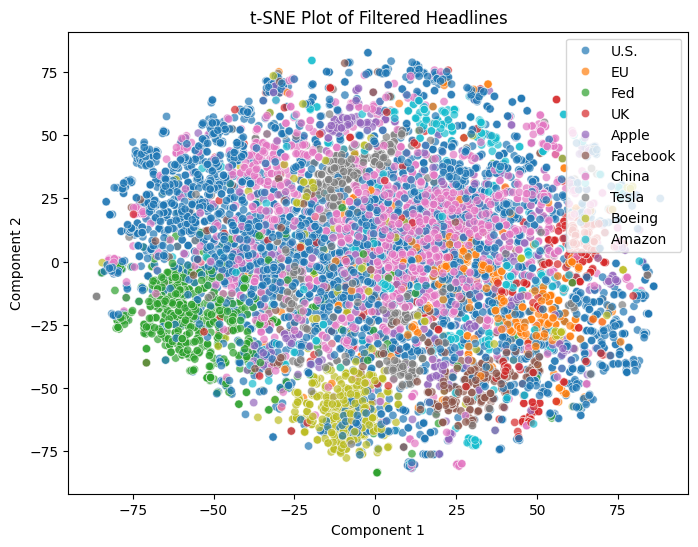

In [69]:
if 'primary_entity_text' in df_filtered.columns:
    labels = df_filtered['primary_entity_text']
else:
    labels = None

plt.figure(figsize=(8, 6))
if labels is not None:
    sns.scatterplot(
        x=X_tsne[:, 0],
        y=X_tsne[:, 1],
        hue=labels,
        palette='tab10',
        alpha=0.7
    )
else:
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)

plt.title("t-SNE Plot of Filtered Headlines")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

In [70]:
headlines = df_reuters['Headlines'].tolist()

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(headlines, show_progress_bar=True)

Batches: 100%|██████████| 1025/1025 [00:15<00:00, 65.52it/s]


In [71]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)
df_reuters['cluster'] = cluster_labels

In [ ]:
cluster_label_dict = {}

for cluster in np.unique(cluster_labels):
    cluster_data = df_reuters[df_reuters['cluster'] == cluster]
    common_entity = cluster_data['primary_entity_text'].dropna().value_counts().idxmax()
    cluster_label_dict[cluster] = common_entity

print("Cluster labels (by most common entity):")
print(cluster_label_dict)

Cluster labels (by most common entity):
{np.int32(0): 'U.S.', np.int32(1): 'U.S.', np.int32(2): 'U.S.', np.int32(3): 'U.S.', np.int32(4): 'China'}


In [73]:
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)

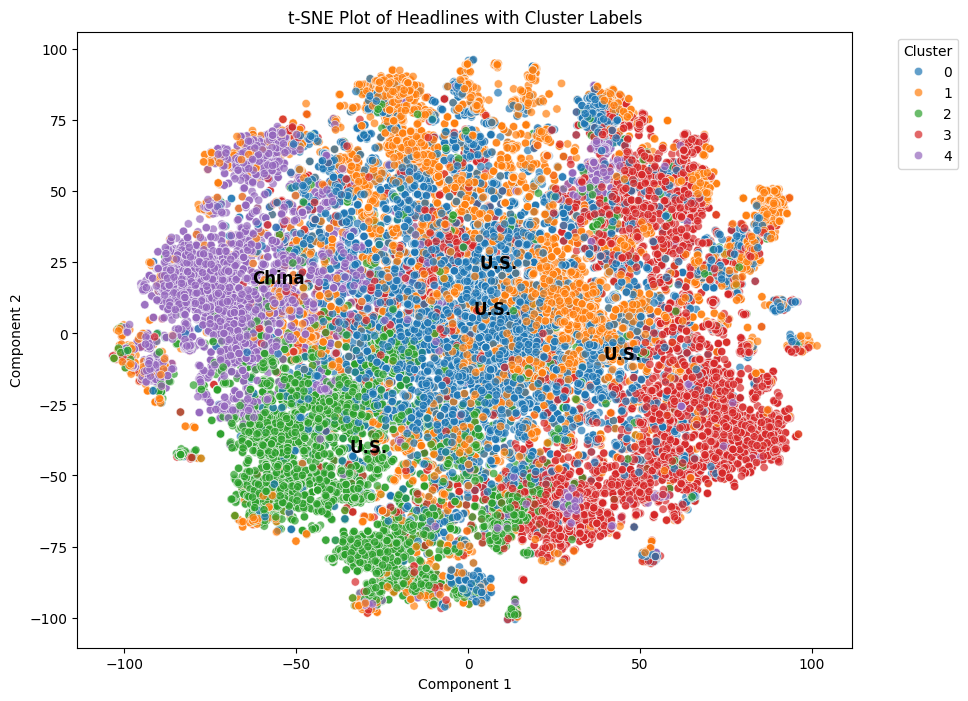

In [74]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=tsne_embeddings[:, 0],
    y=tsne_embeddings[:, 1],
    hue=df_reuters['cluster'],
    palette='tab10',
    alpha=0.7
)

for cluster in np.unique(cluster_labels):
    cluster_points = tsne_embeddings[df_reuters['cluster'] == cluster]
    centroid = cluster_points.mean(axis=0)
    plt.text(centroid[0], centroid[1], cluster_label_dict[cluster],
             fontsize=12, fontweight='bold', horizontalalignment='center')

plt.title("t-SNE Plot of Headlines with Cluster Labels")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [75]:
cluster_terms = {}

for cluster in df_reuters['cluster'].unique():
    cluster_data = df_reuters[df_reuters['cluster'] == cluster]
    headlines_cluster = cluster_data['Headlines']

    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(headlines_cluster)
    feature_names = vectorizer.get_feature_names_out()

    average_scores = tfidf_matrix.mean(axis=0).A1

    sorted_indices = np.argsort(average_scores)[::-1]

    top_n = 5
    top_terms = [(feature_names[i], average_scores[i]) for i in sorted_indices[:top_n]]
    
    cluster_terms[cluster] = top_terms

for cluster, terms in cluster_terms.items():
    print(f"Cluster {cluster}:")
    for term, score in terms:
        print(f"   {term}: {score:.4f}")

Cluster 3:
   coronavirus: 0.0236
   boeing: 0.0231
   max: 0.0175
   737: 0.0173
   says: 0.0152
Cluster 0:
   billion: 0.0225
   ceo: 0.0201
   shares: 0.0165
   sources: 0.0132
   profit: 0.0128
Cluster 1:
   says: 0.0187
   eu: 0.0140
   facebook: 0.0124
   court: 0.0123
   deal: 0.0100
Cluster 2:
   oil: 0.0322
   fed: 0.0243
   stocks: 0.0206
   wall: 0.0205
   street: 0.0191
Cluster 4:
   china: 0.0563
   trade: 0.0463
   says: 0.0317
   trump: 0.0299
   tariffs: 0.0257


In [76]:
finbert = pipeline("sentiment-analysis", model="ProsusAI/finbert", tokenizer="ProsusAI/finbert")

Device set to use mps:0


In [77]:
df_reuters['sentiment'] = df_reuters['Headlines'].apply(lambda text: finbert(text)[0]['label'])

In [78]:
sentiment_mapping = {"positive": 1, "neutral": 0, "negative": -1}
df_reuters['sentiment_score'] = df_reuters['sentiment'].map(sentiment_mapping)

print("\nHeadlines with sentiment analysis:")
print(df_reuters[['Headlines', 'sentiment', 'sentiment_score']].head())


Headlines with sentiment analysis:
                                           Headlines sentiment  \
0  TikTok considers London and other locations fo...   neutral   
1  Disney cuts ad spending on Facebook amid growi...  negative   
2  Trail of missing Wirecard executive leads to B...  negative   
3  Twitter says attackers downloaded data from up...   neutral   
4  U.S. Republicans seek liability protections as...  negative   

   sentiment_score  
0                0  
1               -1  
2               -1  
3                0  
4               -1  


In [79]:
ticker = "SPY"
start_date = df_reuters.Date.min().date()
end_date = df_reuters.Date.max().date()
market_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

market_data['Return'] = market_data['Adj Close'].pct_change()

market_data.columns = [
    col[0] if col[1] == '' else f"{col[0]}_{col[1]}"
    for col in market_data.columns.values
]

[*********************100%***********************]  1 of 1 completed


In [80]:
df_reuters.set_index('Date', inplace=True)
daily_sentiment = df_reuters['sentiment_score'].resample('D').mean()

In [81]:
combined = market_data.join(daily_sentiment, how='left')
combined['sentiment_score'] = combined['sentiment_score'].fillna(0)
combined['target'] = (combined['Close_SPY'].shift(-1) > combined['Close_SPY']).astype(int)
combined.dropna(subset=['target'], inplace=True)

In [82]:
data = combined[['Return', 'sentiment_score']].dropna()

y = data['Return']
exog = data[['sentiment_score']]

In [83]:
model = sm.tsa.statespace.SARIMAX(y, exog=exog, order=(1, 0, 1), 
                                  enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                  586
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1641.576
Date:                Sat, 15 Mar 2025   AIC                          -3275.153
Time:                        13:49:36   BIC                          -3257.673
Sample:                             0   HQIC                         -3268.340
                                - 586                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sentiment_score     0.0065      0.002      3.483      0.000       0.003       0.010
ar.L1              -0.4682      0.050     -9.283      0.000      -0.567      -0.369
ma.L1               0.2098      

/Users/rosleeb/MSDS/Natural Language Processing/nlp_final_project/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rosleeb/MSDS/Natural Language Processing/nlp_final_project/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [84]:
results.save("arimax_model.pkl")